# Implementation of a Mask R-CNN algorithm

In this Notebook, I implement a state-of-the-art Mask R-CNN in order to proceed person detection.
The Mask R-CNN efficiently detects objects within an image and provides a class, a bounding box and a mask for all those objects.

### **Cells for Collaboratory**

In [1]:
!git clone https://github.com/Thomas-Gentilhomme/AI-Project.git

Cloning into 'AI-Project'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 150 (delta 8), reused 45 (delta 5), pack-reused 101
Receiving objects: 100% (150/150), 95.98 MiB | 43.51 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [2]:
%tensorflow_version 1.x
%cd AI-Project/mask_rcnn
import warnings
warnings.filterwarnings('ignore') 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

TensorFlow 1.x selected.
/content/AI-Project/mask_rcnn


### **Cells for local Jupyter Notebook**

In [3]:
%cd mask_rcnn/
import warnings
warnings.filterwarnings('ignore') 

[Errno 2] No such file or directory: 'mask_rcnn/'
/content/AI-Project/mask_rcnn


### **0.0 Libraries importation and setup**

In [3]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


... done downloading pretrained model!


## **Section 1 - Data Preparation**


### **1.1 Load dataset**

In [4]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()

## **Test Mask RCNN Model Implementation**

In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [73]:
###########################
#    Keep individuals     #
###########################

def update_results(results, threshold):
    """
    This function keeps the detections within an image whose score is above a 
    threshold and whose class is 'person'.
    ----------
    Parameters
    ----------
    results: dictionnary
        The output of the predict function of the Mask-RCNN method. Contains the boxes.
        rois: array_like
            Regions of interest: coordinate of the box around an object.
        class_ids: array_like
            Id of the objects according to the MS COCO labels.
        scores: array_like
            Confidence score to belong to the associated id class.
        masks: array_like
            Binary masks of each object.
    threshold: float
        Detector confidence score above which the object is kept.
    ------
    Return
    ------
    persons: dictionnary
        The updated results dictionnary. If no persons in the frame, returns an 
        empty dictionnary.
    """
    
    rois = results['rois']
    class_ids = results['class_ids']
    scores = results['scores']
    masks = results['masks']

    available_individuals_indices = []
    for idx in range(len(class_ids)):
        if (class_ids[idx]) == 1 & (scores[idx] >= threshold):
            available_individuals_indices.append(idx)
  
    rois = rois[available_individuals_indices]
    class_ids = class_ids[available_individuals_indices]
    scores = scores[available_individuals_indices]
    masks = masks[:,:,available_individuals_indices]

    output = {'rois': rois, 'class_ids': class_ids, 'scores': scores, 'masks': masks}

    if output['rois'] is None:
        # Format where no detections meet both conditions.
        output = {'rois': np.array([], dtype=np.int32), 
                  'class_ids': np.array([], dtype=np.int32), 
                  'scores': np.array([], dtype=np.float32), 
                  'masks': np.array([])
                  }

    return output

In [74]:
###########################
#      Visualization      #
###########################

import cv2
from skimage.measure import find_contours


def draw_masks_and_boxes(image, rois, masks, scores, ids, colors, show_masks=True, 
                         show_rois=True, show_captions = False, captions=[], 
                         mask_intensity=0.6, roi_thickness=1, mask_thickness=1, show_masks_countour=True):
    """
    Function that draws the boxes, masks and captions of a frame and returns it.
    ----------
    Parameters
    ----------
    image: array_like
        Frame on which we draw the boxes, masks and captions.
    rois: array_like
        Regions of interest: coordinate of the box around an object.
    masks: array_like
        Binary masks of each object.
    ids: array_like
        Unique ids to identify an individual through the tracking process.
    colors: array_like
        Color palette to differentiale individuals.
    show_masks: boolean
        Allow to masks masks or not.
    show_rois: boolean
        Allow to show boxes or not.
    show_captions: boolean
        Allow to show captions or not.
    captions

    mask_intensity:  float
        Intensity of the color of the mask.
    roi_thickness: int
        Thickness of the boxes.
    mask_thickness: int
        Thickness of the masks coutour.
    ------
    Return
    ------
    masked_image: array_like
        The frame with the drawn masks, boxes, ids and scores.
    """
    
    N = rois.shape[0]

    frame_height, frame_width = image.shape[:2]

    masked_image = image.astype(np.uint8).copy()
    masked_image = cv2.UMat(masked_image).get()

    for i in range(N):
        # Loop over all instances.
        C = len(colors)
        color = colors[i % C]  

        # Bounding box
          # TO DO : dashed lines
        y1, x1, y2, x2 = rois[i]
        if show_rois:
            masked_image = cv2.rectangle(masked_image,(x1,y2),(x2,y1),color,roi_thickness)

        # Caption
        if not show_captions :
            #class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = 'Person'
            #label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]

        cv2.putText(img = masked_image, text = caption, org = (x1,y1+8), 
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.35, 
                    color = color, thickness = 1
                    )
        
        # Mask
        mask = masks[:, :, i]
        if show_masks:
            for c in range(3):
                # Attenuate original area and add attenuate color over it.
                masked_image[:, :, c] = np.where(mask == 1, 
                                                 masked_image[:, :, c] * \
                                                 (1 - mask_intensity) + \
                                                 mask_intensity * color[c] * 255,
                                                 masked_image[:, :, c]
                                                 )

            # Mask Contour
            '''
            Using a padding to apply the skimage.measure.find_coutours method and
            keep edges.
            '''
            padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
            padded_mask[1:-1, 1:-1] = mask
            contours = find_contours(padded_mask, 0.5)
            '''
            Remove the padding and flip the coordinates.
            '''
            flip_contours = [np.fliplr(verts) - 1 for verts in contours]
            for contour in flip_contours:
              '''
              In case mask parts are separated from each other.
              This is the case in some treaky detection.
              '''
              cv2.polylines(masked_image, pts = [np.int32(contour)], 
                            isClosed = True, color = color, thickness = mask_thickness
                            )
            
    return masked_image


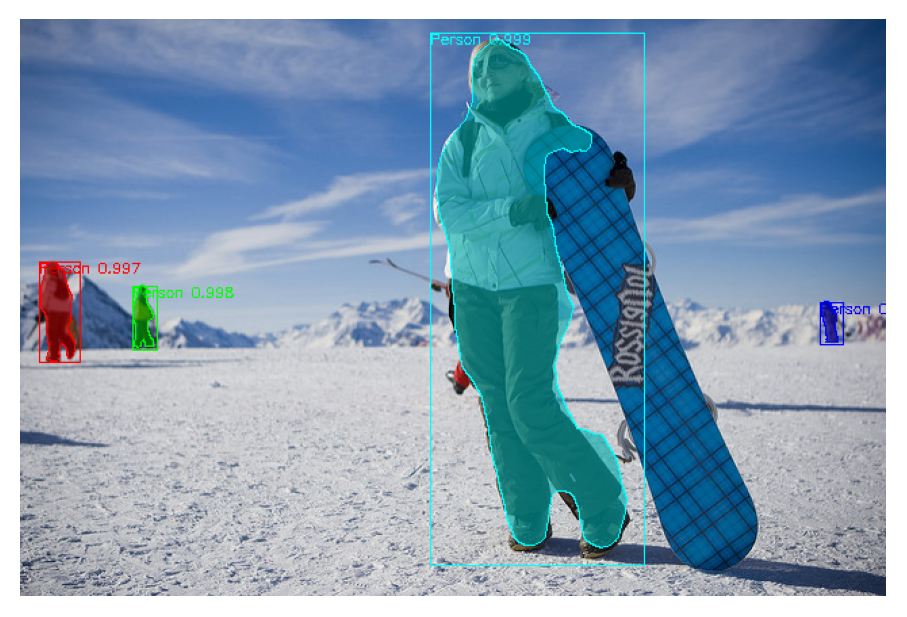

In [47]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
result = model.detect([image], verbose=0)[0]

# Visualize results
'''
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']
'''
class_names = ['person']

colors = [(0,255,255),(0,255,0),(255,0,0),(0,0,255),(255,0,255),(255,255,0),
          (128,128,0),(0,128,128),(128,0,0),(128,0,128)]

threshold = 0.8

result = update_results(result, threshold)

ids = []

masked_image = draw_masks_and_boxes(image, result['rois'], result['masks'], 
                                    result['scores'], ids, colors
                                    )

frame_height, frame_width = image.shape[:2]
_, ax = plt.subplots(1, figsize=(16, 16))
ax.set_ylim(frame_height + 10, -10)
ax.set_xlim(-10, frame_width + 10)
ax.axis('off')
ax.imshow(masked_image.astype(np.uint8))
plt.show()

### **TEST WITH A SINGLE VIDEO**

In [69]:
VideoFile = '../test.mp4'

In [70]:
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

cap = cv2.VideoCapture(VideoFile)

if (cap.isOpened()== False): 
    print("Error opening video stream or file")

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

out = cv2.VideoWriter('../mask_test.mp4',cv2.VideoWriter_fourcc('M','J','P','G'), 15, (frame_width,frame_height))

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
count = 0

while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if ret == True:
        # Our operations on the frame come here
        #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        
        frame_result = model.detect([frame], verbose=0)[0]
        frame_result = update_results(frame_result, threshold)
        #masked_frame = visualize.display_instances(frame, frame_result['rois'], frame_result['masks'], frame_result['class_ids'], class_names, frame_result['scores'])
        masked_frame = draw_masks_and_boxes(frame, frame_result['rois'], frame_result['masks'], 
                                            frame_result['scores'], ids, colors
                                            )
        # Display the resulting frame
        #cv2.imshow('masked_frame', masked_frame)
        #cv2_imshow(masked_frame)

        # Write the resulting frame in a new video file
        out.write(masked_frame)
        clear_output(wait=True)

        count += 1
        if (count % 10) == 0:
          clear_output(wait=True)
          print(str((count/total_frames)*100)+'%')
    else:
        clear_output(wait=True)
        print(str((count/total_frames)*100)+'%')
        break

# When everything done, release the capture
out.release()
cap.release()
cv2.destroyAllWindows()

100.0%


# END TO END DETECTION AND TRACKING

In [71]:
class Individuals():
  '''
  Class used to store the caracteristics of each detected individuals on a frame.
  ----------
  Parameters
  ----------
  rois: array-like
    Coordinates of the bounding boxes (rois = Regions of Interest)
  sores: array-like
    Confidence scores to belong to the associated class.
  masks: array-like
    Binary masks of the detected individuals on the associated frame.
  class_ids: array-like
    Class id of the detection according to MS COCO nomenclature (always '1' in our case)
  track_ids: array-like
    Unique ids to identify an individual through the tracking process.
  img: array-like
    The frame associated to these individuals.
  ----------
  Attributes
  ----------
  rois: array-like
    Coordinates of the bounding boxes (rois = Regions of Interest)
  scores: array-like
    Confidence scores to belong to the associated class.
  masks: array-like
    Binary masks of the detected individuals on the associated frame.
  class_ids: array-like
    Class id of the detection according to MS COCO nomenclature (always '1' in our case)
  track_ids: array-like
    Unique ids to identify an individual through the tracking process.
  img: array-like
    The frame associated to these individuals.
  '''

  def __init__(self):
    self.rois = []
    self.scores = []
    self.masks = []
    self.class_ids = [] 
    self.track_ids = []
    self.img = []

In [75]:
class MaskRCNN():
  """
  Create an instance of a MaskRCNN object based on the keras implementation by 
  Matterport: https://github.com/matterport/Mask_RCNN.
  Mask RCNN in an end-to-end detection algorithm. Given an image, it returns a 
  list of object ids and the corresponding boxes, masks and scores.
  This model has been pre-trained on the MS COCO data set.
  ---------
  Parameter
  ---------
  model:
  ---------
  Attribute
  ---------
  model:

  """
  def __init__(self, model, threshold):
    self.model = model
    self.threshold = threshold
    self.individuals = Individuals()
  
  def predict(self, frame, verbose=0):
    """
    ----------
    Parameters
    ----------
    frame: array_like
      The image on which the MaskRCNN detector is apply.
    ------
    Return
    ------
    output: dictionnary
      It contains four lists: one for the objects boxe coordinates, one for the 
      objects id, one for the objects score and one for the objects binary mask.
    """

    output = self.model.detect([frame], verbose=verbose)[0]
    
    # Keep all objects that are a person with a confidence score above a threshold
    output = utils.update_results(output, self.threshold)

    #TO TO : case where nothing is detected ???

    self.individuals.rois = output['rois']
    self.individuals.masks = output['masks']
    self.individuals.class_ids = output['class_ids']
    self.individuals.scores = output['scores']
    self.individuals.img = frame

    return self.individuals

In [76]:
class DeepSORT():
  """
  Create an instance of a DeepSORT object based on the implementation by Nicolai 
  Wojke: https://github.com/nwojke/deep_sort.
  The multi-cams adapatation has been inspired by: 
  https://github.com/LeonLok/Multi-Camera-Live-Object-Tracking.
  The idea of this class is to perform a tracking of the detected individuals.
  DeepSORT is a tracking algorithm. It holds a 'track' object for each detected
  individual. Newly created tracks are classified as 'tentative' until enough 
  evidence has been collected. Then, the track state is changed to 'confirmed'. 
  Tracks that are no longer alive are classified as 'deleted' to mark them for 
  removal from the set of active tracks.

  In the initialization, we simply create the tracker object based on cosine metric.
  ----------
  Parameters
  ----------
  max_cosine_distance: float
    The matching threshold. Samples with larger distance are considered an invalid 
    match. It is used to associate the detections with the existing tracks.
    Associations with cost larger than this value are disregarded.
  nn_budget:

  max_age : int
    Maximum number of missed misses before a track is deleted.
  n_init : int
    Number of consecutive detections before the track is confirmed. The
    track state is set to `Deleted` if a miss occurs within the first
    `n_init` frames.
  ----------
  Attributes
  ----------
  max_age : int
    Maximum number of missed misses before a track is deleted.
  n_init : int
    Number of frames that a track remains in initialization phase.
  metric: nn_matching.NearestNeighborDistanceMetric
    A distance metric for measurement-to-track association.
  tracker: Tracker
    This is the multi-target tracker of the Deep Sort Algorithm. It initializes a 
    tracking list and a Kalman filter.
  """
  def __init__(self, max_cosine_distance=0.2, nn_budget=None, max_age=30, n_init=3):

    self.max_age = max_age
    self.n_init = n_init
    self.metric = nn_matching.NearestNeighborDistanceMetric(
        "cosine", max_cosine_distance, nn_budget
        )
    self.tracker = Tracker(self.metric,self.max_age)


  def perform_track(self,frame,individuals):
    '''
    The tracking method. It makes the link between our videos, the outputs of the 
    detector and the used DeepSORT architecture. It allows each identical detection 
    to have a unique ID through the videos.
    ----------
    Parameters
    ----------
    frame: array_like
      The current frame from which we track the individuals.
    output: Individuals
      The output of the detector from which we only kept the individuals with more 
      than a certain threshold confidence score.
    ------
    Return
    ------
    output: Individuals
      The updated output after performing the tracking method. 
    '''
    frame_height, frame_width, _ = frame.shape

    # Generate detections objects from the output of the Mask RCNN Detector.
    '''
    Detection class represents a bounding box detection in a single image.
    '''
    detections=[]
    for roi, score in zip(individuals.rois,individuals.scores):
      y1, x1, y2, x2 = roi
      box = (x1, y1, x2 - x1, y2 - y1)
      detections.append(Detection(box,score,frame)) 
    
    # Run non-maxima suppression. 
       # TO DO : try without NMS (maybe unuseful as already in mask rcnn)
    boxes = np.array([d.tlwh for d in detections])
    scores = np.array([d.confidence for d in detections])
    indices = preprocessing.non_max_suppression(boxes, self.nms_max_overlap, scores)
    detections = [detections[i] for i in indices]

    # Update tracker.
    '''
    tracker.predict() propagates track state distributions one time step forward.

    It is called once every time step (before 'update') and for each track of the 
    tracks list, it propagates the state distribution to the current time step using 
    a Kalman filter prediction step. It also increments each track age.
    '''
    self.tracker.predict()
    '''
    tracker.update(detections) performs the actual measurement update and track 
    management.

    Is starts by runing a cascade matching between all detections and tracks on
    the last 'max_age' time steps. For that, the function splits the track set 
    into 'confirmed' and 'unconfirmed' tracks ('unconfirmed' means either 'tentative' 
    or 'deleted').

    Then it associates the 'confirmed' tracks using appearance features. For that,
    the function computes a cost matrix based on the chosen metric between all 
    tracks and all detection and performs a minimal cost matching using the 
    sklearn.utils.linear_assignment function.

    Then it associates remaining tracks together with 'unconfirmed' tracks using 
    IOU matching (= Computer intersection over union Matching).

    Finally, it updates the track set and the distance metric. For that, it updates
    the matched tracks (by updating the Kalman Filters mean and covariance, by
    adding the detection features to the associated track features and by changing
    'Tentative' state to 'Confirmed' if necessary), it marks as "missed" the tracks 
    that hasn't been associated with any match at the current time step (and deletes 
    them after 'max_age' missed steps) and it initiates a track for the detections 
    that hasn't been associated with any track.
    '''
    self.tracker.update(detections)


    # Count the number of confirmed trackers that we will output to the system
    '''
    total_track = 0
    for track in self.tracker.tracks:
      total_track+=1
    '''
    total_track = len(self.tracker.tracks)
    individuals.track_ids = np.zeros((total_track))
    #individuals.tracked_rois = np.zeros(shape=(track_count,4))
    for i, track in enumerate(self.tracker.tracks):
      #x1, y1, x2, y2 = track.to_tlbr()
      #individuals.tracked_rois[i] = (y1, x1, y2, x2)
      individuals.track_ids[i] = track.track_id

    return individuals


## librairies and paths

In [79]:
from time import time
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

VideoFile = '../test.mp4'
OutputVideo = '../mask_test.mp4'
max_age = 10

colors = [(0,255,255),(0,255,0),(255,0,0),(0,0,255),(255,0,255),(255,255,0),
          (128,128,0),(0,128,128),(128,0,0),(128,0,128)]

threshold = 0.8

## Run Mask-RCNN detector + tracker for each frame of a video.

In [ ]:
def tracking(detector, tracker, VideoFile, OutputVideo)

  cap = cv2.VideoCapture(VideoFile)
  detector = detector
  tracker = tracker

  if (cap.isOpened()== False): 
      print("Error opening video stream or file")

  frame_width = int(cap.get(3))
  frame_height = int(cap.get(4))

  out = cv2.VideoWriter(
      OutputVideo,
      cv2.VideoWriter_fourcc('M','J','P','G'),
      30,
      (frame_width,frame_height)
      )

  # Take initial time to measure time performance and put it in a list
  times = [time()]

  while(cap.isOpened()):
      # Capture frame-by-frame
      ret, frame = cap.read()
      
      if ret == True:
          #### Operations to perform over each frame
          
          # Apply detector to the frame
          frame_result = detector_mask_rcnn.predict(frame)
          frame_result = tracker.perform_track(frame,frame_result)

          # Create an output image by drawing the corresponding masks over the 
          # detected persons of the frame
          masked_frame = utils.draw_masks_and_boxes(image, frame_result['rois'], 
                                              frame_result['masks'], 
                                              frame_result['scores'], 
                                              frame_result['track_ids'], colors
                                              )
          # Display the resulting frame
          #cv2.imshow('masked_frame', masked_frame)
          #cv2_imshow(masked_frame)

          # Write the resulting frame in a new video file
          out.write(masked_frame)
          clear_output(wait=True)
          if cv2.waitKey(1) & 0xFF == ord('q'):
              break
      else:
          break
      times.append(time())

  # When everything done, release the capture
  out.release()
  cap.release()
  clear_output(wait=True)

  return times

In [ ]:
detector = MaskRCNN(
      modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config),
      threshold=0.8
      )

tracker = DeepSORT(
     max_cosine_distance=0.2, nn_budget=None, max_age=30, n_init=3
      )

times_colab_GPU = tracking(detector, tracker, VideoFile, OutputVideo)

In [ ]:
import pickle
with open("times_colab_GPU.txt", "wb") as fp:   #Pickling
  pickle.dump(times_colab_GPU, fp)

In [ ]:
with open("times_colab_GPU.txt", "rb") as fp:   # Unpickling
  times_colab_GPU = pickle.load(fp)

## old cells

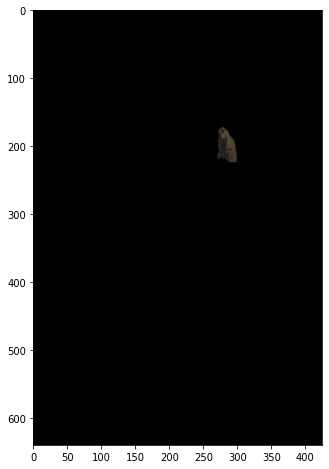

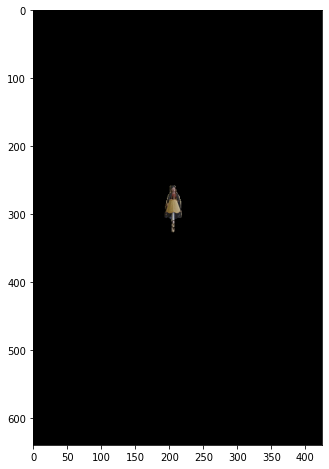

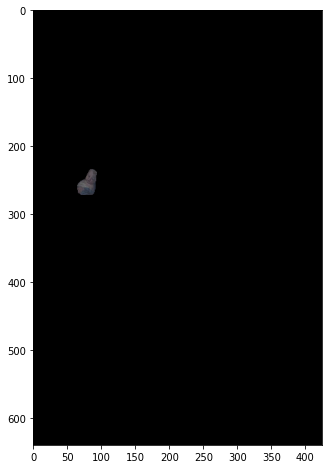

In [139]:
import imutils

def show_mask(r,image):
    mask = r['masks']
    for i in range(mask.shape[2]):
        #temp = imutils.resize(image, width = 500)
        temp = image.copy()
        for j in range(temp.shape[2]):
            temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
        plt.figure(figsize=(8,8))
        plt.imshow(temp)
        #cv2.imwrite("./images/mask"+str(i)+".png",temp)
        plt.show()

show_mask(result,image)

In [ ]:
def keep_persons(results):

    persons = {'rois': None, 'class_ids': None, 'scores': None, 'masks': None}
    for i, class_id in enumerate(results['class_ids']):

        if (class_id) == 1 & (results['scores'][i] >= 0.8):
            "The mask is around a person --> we keep it"
            if persons['rois'] is None :
                persons['rois'] = np.array([results['rois'][i]], dtype=np.int32)
                persons['class_ids'] = np.array([results['class_ids'][i]], dtype=np.int32)
                persons['scores'] = np.array([results['scores'][i]], dtype=np.float32)
                persons['masks'] = np.expand_dims(np.array(results['masks'][:,:,i]), axis=2)
            else :
                persons['rois'] = np.concatenate((persons['rois'], [results['rois'][i]]))
                persons['class_ids'] = np.concatenate((persons['class_ids'], [results['class_ids'][i]]))
                persons['scores'] = np.concatenate((persons['scores'], [results['scores'][i]]))
                persons['masks'] = np.concatenate((persons['masks'], np.expand_dims(results['masks'][:,:,i], axis=2)), axis=2)

    if persons['rois'] is None:
        persons = {'rois': np.array([], dtype=np.int32), 'class_ids': np.array([], dtype=np.int32), 'scores': np.array([], dtype=np.float32), 'masks': np.array([])}
    return persons

<IPython.core.display.Javascript object>

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


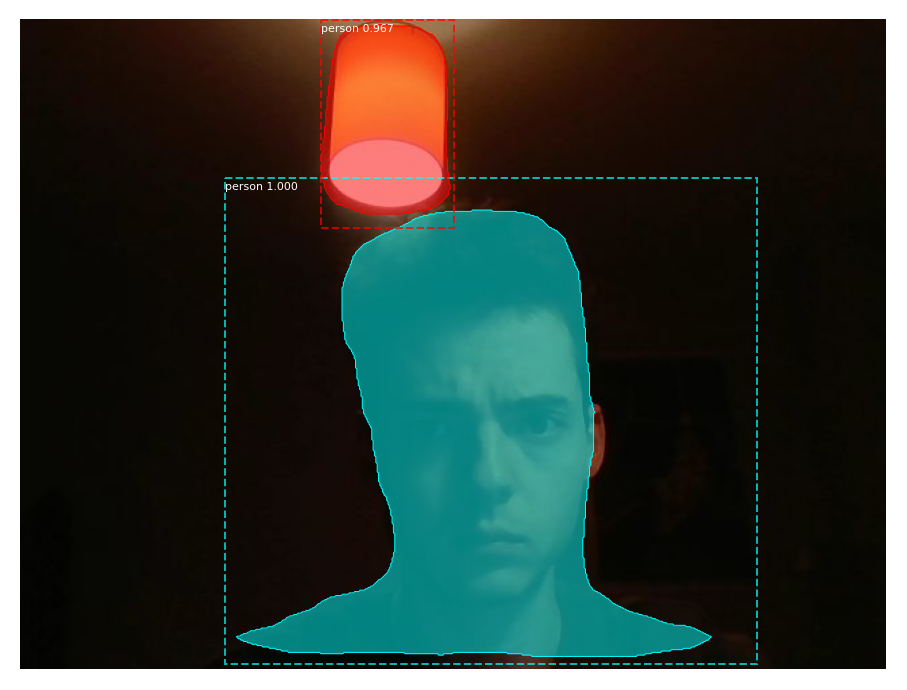

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


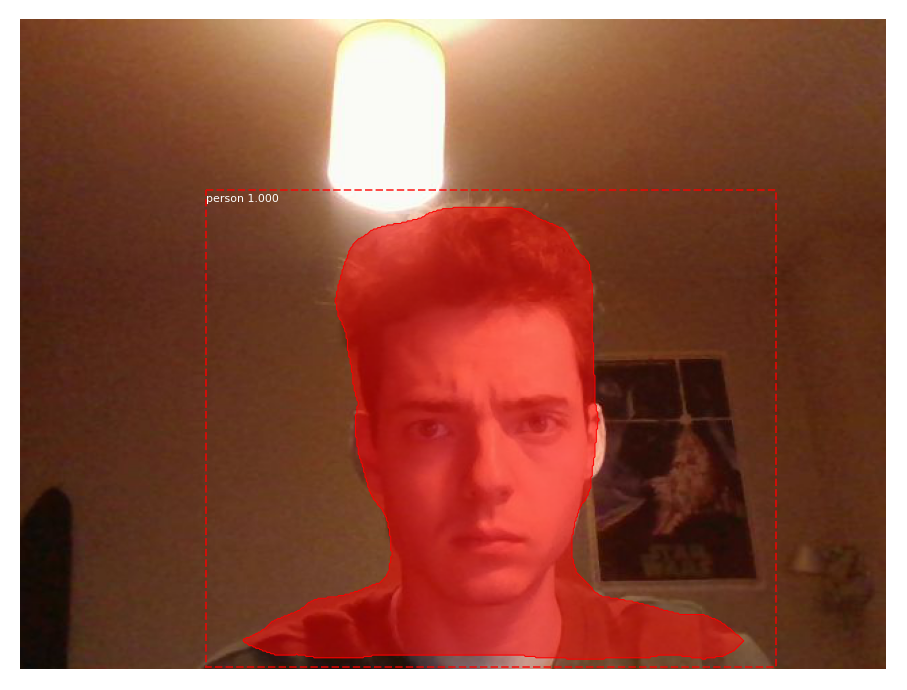

Processing 1 images
image                    shape: (480, 640, 3)         min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


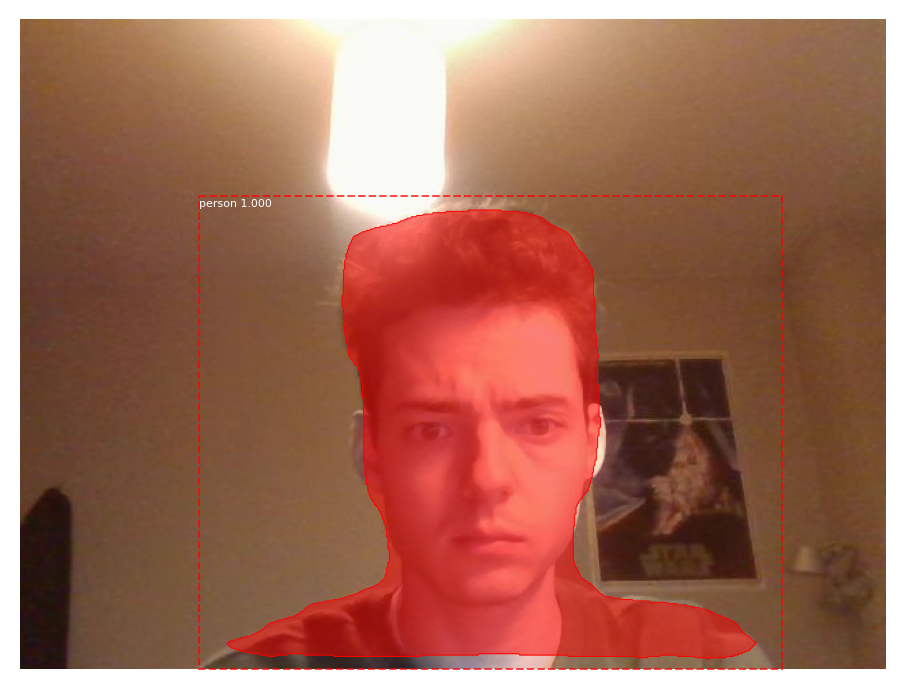

Processing 1 images
image                    shape: (480, 640, 3)         min:    6.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


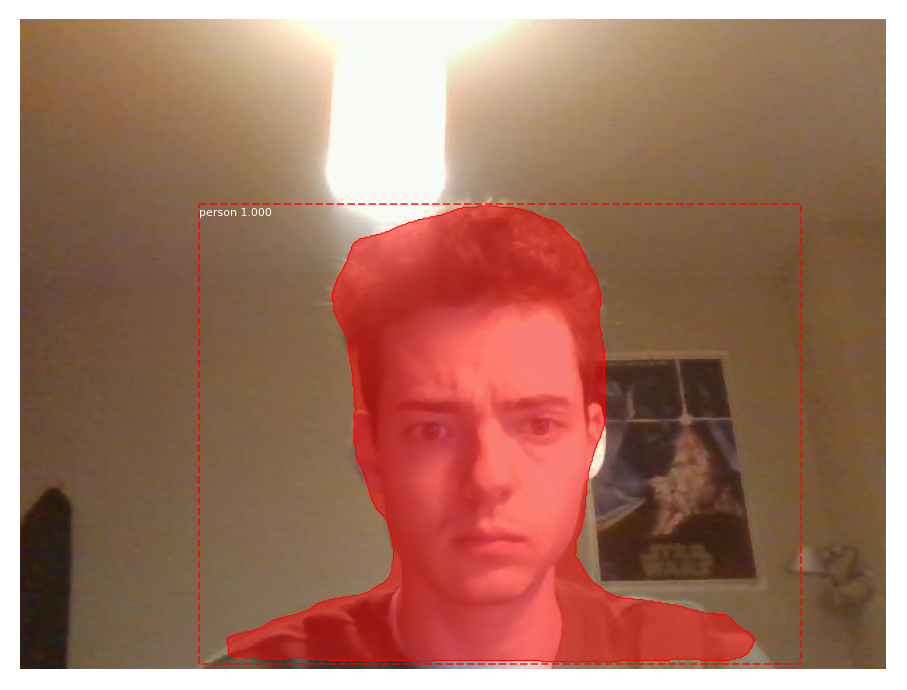

Processing 1 images
image                    shape: (480, 640, 3)         min:   14.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


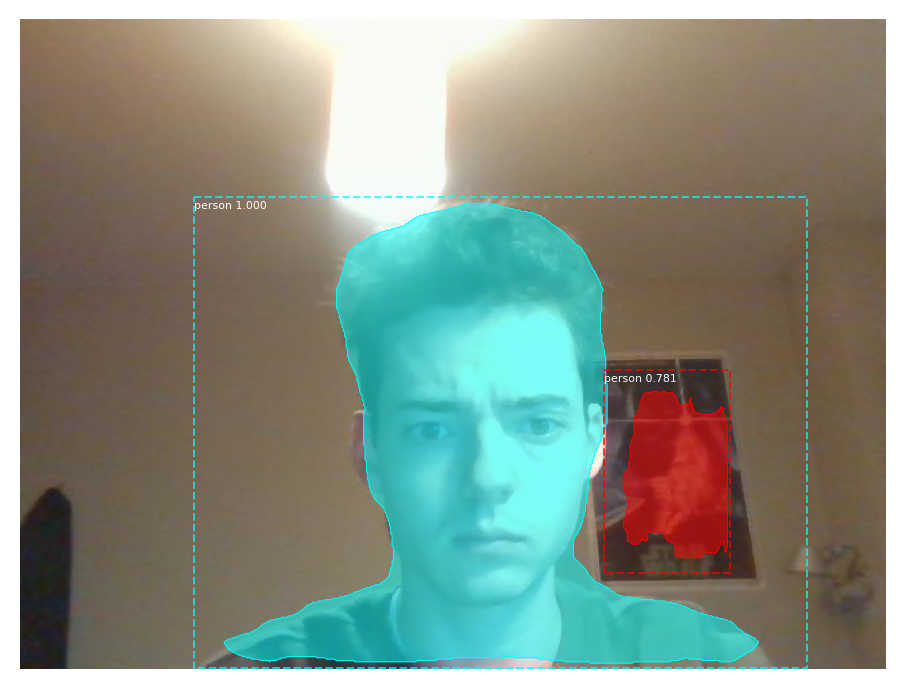

In [ ]:
import IPython
from google.colab import output
from google.colab.patches import cv2_imshow

import time
import sys
import numpy as np
import cv2

from PIL import Image
from io import BytesIO
import base64
import logging

def data_uri_to_img(uri):
    """convert base64image to numpy array"""
    try:
        image = base64.b64decode(uri.split(',')[1], validate=True)
        # make the binary image, a PIL image
        image = Image.open(BytesIO(image))
        # convert to numpy array
        image = np.array(image, dtype=np.uint8); 
        return image
    except Exception as e:
        logging.exception(e);print('\n')
        return None

def run_algo(imgB64):
    """
    in Colab, run_algo function gets invoked by the JavaScript, that sends N images every second

    params:
    image: image
    """
    image = data_uri_to_img(imgB64)  
    if image is None:
        print("At run_algo(): image is None.")
        return

    try:
    # Run detection
    results = model.detect([image], verbose=1)
    # Visualize results
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

    except Exception as e:
    logging.exception(e)
    print('\n')

# register this function, so JS code could call this
output.register_callback('notebook.run_algo', run_algo)

# put the JS code in cell and run it
take_photo()

In [ ]:
'''
## Camera Capture
Using a webcam to capture images for processing on the runtime.
Source: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi
'''

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      // show the video in the HTML element
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // prints the logs to cell
      let jsLog = function(abc) {
        document.querySelector("#output-area").appendChild(document.createTextNode(`${abc}... `));
      }

      // Wait for Capture to be clicked.
      // await new Promise((resolve) => capture.onclick = resolve);

      for (let i = 0; i < 5; i++) {
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        img = canvas.toDataURL('image/jpeg', quality);

        // show each captured image
        // let imgTag = document.createElement('img');
        // imgTag.src = img;
        // div.appendChild(imgTag);

        jsLog(i + "sending")
        // Call a python function and send this image
        google.colab.kernel.invokeFunction('notebook.run_algo', [img], {});
        jsLog(i + "SENT")

        // wait for X miliseconds second, before next capture
        await new Promise(resolve => setTimeout(resolve, 250));
      }

      stream.getVideoTracks()[0].stop(); // stop video stream
    }
    ''')
  display(js) # make the provided HTML, part of the cell
  data = eval_js('takePhoto({})'.format(quality)) # call the takePhoto() JavaScript function

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


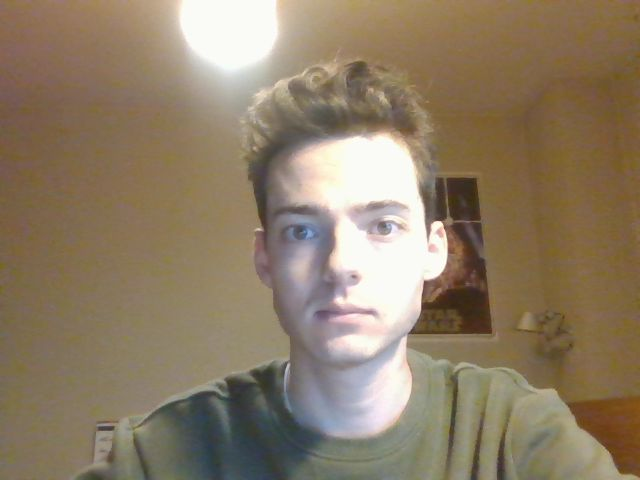

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))